In [100]:
#  Organize the data in a way suitable to use for statistics.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

# ------ LOAD data-tables ---------------------------------------------------- 
# List of clinical table with features and timepoints
# => ClinicalData_Klinisk.csv ------------ Patients list and clinical data  (sheets "Klinik fra Randi")
#                                        - (including medications, treatments etc...)
# => ClinicalData_Oversikt.csv ----------- Sample list of all timepoint measurements (sheet "Oversikt")
#                                        - (in theory 5 each patient)
# => Lipoproteinene_Combined2.csv -------- Lipoprotein measurements (blood serum)
# => Metabolittene_comb_final_clean.csv -- Metabolomics measurments (blood serum)

path_Klinisk  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Klinisk.csv" 
path_Oversikt = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Oversikt.csv" 
path_Lipopro  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Lipoproteinene_Combined2.csv" 
path_Metabol  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Metabolittene_comb_final_clean.csv" 

root_path = os.path.dirname(path_Lipopro)
             
# Load clinical data files, Lipoprotein and Metabolites measurments files 
# NOTE: There are some redundant columns!
CD_klinisk = pd.read_csv( path_Klinisk,  header=1, index_col=False)
CD_oversik = pd.read_csv( path_Oversikt, header=0, index_col=False)
LP_measure = pd.read_csv( path_Lipopro,  header=0, index_col=False)
MB_measure = pd.read_csv( path_Metabol,  header=0, index_col=False)


# ------ PRUNING the data ----------------------------------------------------
# Extract the timepoints as defined by Guro. We could also redifine by looking 
# dates or use dates to find matching measurments between different dataframes 
sele_oversik  = [ "PatientID", 
                  "Samplenames lipo", "Names date modified", "Samling date", 
                  "Dato stråleterapi", 
                  "Timepoint", "Timepoint_kodet",
                  "Alder", "BMI", 
                  "HEr2 ", "ER ", "PGR","kjemo", "herceptin" , "hormornbeh",
                  "FatPAS.1", "FatPAS.2", "FatPAS.3", "FatPAS.4", "FatPAS.5"]
CD_samples  = CD_oversik.loc[:,sele_oversik]

# Simplify the names of the Metabolites dataframe columns, removing the unit
names = MB_measure.columns
MB_measure.columns = [xx.split(" (RawConc)")[0] for xx in names]

# Rename column e.g. "Samplenames lipo" in CD_oversik === "name" in LP_measure
CD_samples = CD_samples.rename(columns={"Samplenames lipo": "Samplename"})
LP_measure = LP_measure.rename(columns={"name": "Samplename"})
MB_measure = MB_measure.rename(columns={"Sample Name": "Samplename"})
CD_samples = CD_samples.rename(columns={"HEr2 ": "HER2"})
CD_samples = CD_samples.rename(columns={"ER ": "ER"})

# Insert a "PatientID" column in LP and MB dataframes (redundant but good practice)
LP_measure.insert( loc=1, column="PatientID", value=CD_samples["PatientID"])
MB_measure.insert( loc=1, column="PatientID", value=CD_samples["PatientID"])


# ! Ensure that the different DFs (CD, LP and MB) have the exact same set of 
#   samples in their list. Use "Samplename" compare and remove those samples
#   that appear only in one dataframe.
# NOTE: check manually on the list what we are actually removing !!!
#       Specifically, LP have less samples than MP and CD
# Use set-difference to find missing samples in LP_measure, then reomve those
# from the list. Finally, subset DFs selecting only common samples
miss_nn = np.setdiff1d( CD_samples["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( CD_samples["Samplename"], miss_nn )
CD_samples = CD_samples.loc[CD_samples["Samplename"].isin(list_nn)]

# As above, but between LP_measure and MB_measure
# NOTE: MB_measure has repeated measurments for a couple of samples !!!
miss_nn = np.setdiff1d( MB_measure["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( MB_measure["Samplename"], miss_nn )
MB_measure = MB_measure.loc[MB_measure["Samplename"].isin(list_nn)]

# Remove quality control measurments: strings starting with "QC"
mask_QC = ["QC" not in xx   for xx in LP_measure["Samplename"]]
CD_samples = CD_samples.loc[ mask_QC, : ]
LP_measure = LP_measure.loc[ mask_QC, : ]
MB_measure = MB_measure.loc[ mask_QC, : ]


# At this point we should have the exact same entries in both DataFrames. 
# Sort-by name columns "Samplename" and then remove uncategorized timepoints.
CD_samples = CD_samples.sort_values("Samplename")
LP_measure = LP_measure.sort_values("Samplename")
MB_measure = MB_measure.sort_values("Samplename")


# --- Selection by HER2 analysis
# Correct Syntax errors in Time column ('pre ' (with space) instead of 'pre')
idx = CD_samples.index[CD_samples['Timepoint']== 'pre '].tolist()
CD_samples.loc[idx] = CD_samples.loc[idx]['Timepoint'] = 'pre'

# Remove the samples tagged "pre" in HER2 column
#mask = np.array(CD_samples["PGR"] == -100)
# Remove 'nan' values (CD_samples['Timepoint']== '?')
mask = CD_samples["Timepoint_kodet"].isnull().values
CD_samples = CD_samples.loc[ ~mask, : ]
LP_measure = LP_measure.loc[ ~mask, : ]
MB_measure = MB_measure.loc[ ~mask, : ]

# Now all DFs the same set of measurements sorted in the same order (Samplename)
# Thus, we reindex th143098
e rows in all DFs to be the same.
CD_samples = CD_samples.reset_index(drop=True)
LP_measure = LP_measure.reset_index(drop=True)
MB_measure = MB_measure.reset_index(drop=True)

# ------ SAVE ----------------------------------------------------------------
# Save as Python-Ready .csv file
CD_samples.to_csv( root_path + "/PyR_Sample_ClinikData.csv"  , header=True, index=True)
LP_measure.to_csv( root_path + "/PyR_Lipoproteine.csv", header=True, index=True)
MB_measure.to_csv( root_path + "/PyR_Metabolittene.csv", header=True, index=True)

In [151]:
# Go through specific columns of the metadata to see how many categories 
# there are and how many sample there are for each of them.
col_name = "FatPAS.3"
data_column = CD_samples.loc[CD_samples["Timepoint_kodet"]==5, col_name]      # CD_samples[col_name]
categ = data_column.unique()

for cc in categ:
    tot = ( data_column == cc).sum()
    print(cc, " - ",  tot)


nan  -  0
2.0  -  62
4.0  -  5
1.0  -  51
3.0  -  22


In [118]:
# In some columns, values are tagged "pre" when they are empty. Those samples
# must be excluded from further analysis

# HER2 receptor:    0 - negative
#                   1 - positive
#                   2 - ikke utført === unknown

# ER - estrogen:    1 - positive
#                   2 - negative
#                   3 - DCIS
#                   4 - for lite === insufficient

# PGR progesteron:  1 - ikke utført === unknown
#                   2 - negative
#                   3 - positive

# kjemo-tterapi:    0 - no chemo
#                   1 - adjuvant
#                   2 - neoadjuvant
#                   3 - adj. + neoadj.

# herceptin:        0 - ingen     === unknown
#                   1 - før/under ===before/during
#                   2 - etter     === afer

# hormornbeh(total):0 - no
#                   1 - yes

# FatPAS.X - fatigue: 1 - not at all
#                     2 - a little
#                     3 - quite a bit
#                     4 - very much

In [201]:
import sys
# Add as desired to the list of known working paths for Python 
sys.path.append('F:/Python/')

import mbc_PLS_basic
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
#import importlib
#importlib.reload(mbc_PLS_basic)


# --- 0 --- Parameters for the cross validation ------------------------------
max_N_comp = 10           # Maximum number of components to tes
outer_PropSele = 0.20     # proportion train-to-test to use
inner_PropSele = 0.20    
outer_loop  = 15          # cycles number to perform double cross val.
inner_loop  = 15
min_cat = 0
max_cat = 1

# Transform categories into 0 and 1 response values
transform_cat = True
if transform_cat == True :
    min_rval = 0
    max_rval = 1
    p_threshold = 0.5                       # predicted probability threshold
else:
    min_rval = min_cat
    max_rval = max_cat
    p_threshold = (min_cat+max_cat) / 2     # predicted probability threshold


# Column name for the response variable to use in PLS-DA
unique_PatientID_Col = "PatientID"
Response_Col         = "FatPAS.5"


# --- 1 --- Prepare the DataFrames in the appropriate format -----------------
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
YY = CD_samples.copy()
dataset = pd.concat([LP_measure, MB_measure.iloc[:,2:]], axis = 1)

# Select only samples from a secific time point
mask = YY["Timepoint_kodet"]== 5
YY = YY.loc[mask]
dataset = dataset.loc[mask]

# Remove samples with NaN values in Response_Col
mask = YY[Response_Col].isnull().values
YY = YY.loc[ ~mask, : ]
dataset = dataset.loc[ ~mask, : ]

# FATIGUE: divide Response_Col in only two categories 
#  - 0, no fatigue (original category 1)
#  - 1, some to severe (original categories 2, 3 and 4)
YY.loc[ YY[Response_Col]==1, Response_Col] = 0
YY.loc[ YY[Response_Col]>=2, Response_Col] = 1

# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( dataset , 4)
XX, YY = CrossSelect_TwoTables( XX_vars_scaled, YY, Response_Col, [min_cat,max_cat], transform_cat ) 



# --- 2 --- Cross-validation of PLS ------------------------------------------
accuracy, comparPred, outerMSE, innerMSE = optimise_PLS_CrossVal(
                                              XX, YY, max_N_comp, unique_PatientID_Col,
                                              Response_Col, min_rval, max_rval, p_threshold , 
                                              outer_loop, inner_loop, outer_PropSele, inner_PropSele,
                                              False)

accuracy["Mean"] = accuracy.mean(axis=1)
accuracy

,o1,o2,o3,o4,o5,o6,o7,o8,o9,o10,o11,o12,o13,o14,o15,Mean
Best_nLV,10.000000,8.000000,4.000000,10.000000,9.000000,10.000000,10.000000,10.0,5.000000,10.000000,10.000000,10.000000,5.000000,10.000000,8.000000,8.600000
Accuracy,0.500000,0.500000,0.607143,0.571429,0.678571,0.571429,0.607143,0.5,0.500000,0.392857,0.535714,0.571429,0.642857,0.464286,0.607143,0.550000
Specificity,0.400000,0.428571,0.636364,0.416667,0.444444,0.200000,0.444444,0.5,0.166667,0.571429,0.500000,0.666667,0.428571,0.500000,0.500000,0.453588
Selectivity,0.444444,0.428571,0.764706,0.562500,0.736842,0.444444,0.631579,0.5,0.409091,0.357143,0.562500,0.684211,0.666667,0.428571,0.714286,0.555704


In [177]:
pd.DataFrame(accuracy["Mean"])

,Mean
Best_nLV,8.733333
Accuracy,0.535714
Specificity,0.268255
Selectivity,0.236029


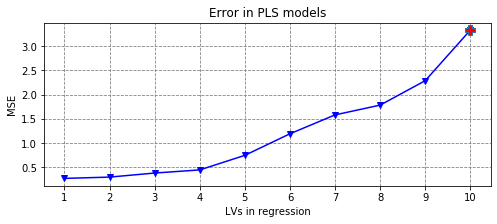

In [203]:
plot_metrics(outerMSE.iloc[ 0:1, :].T.values, 'MSE', 'min')

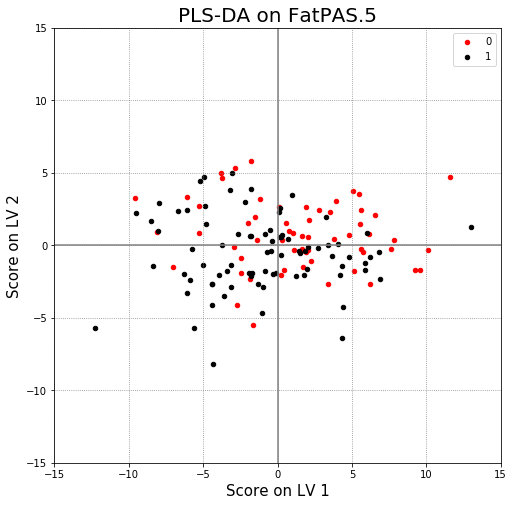

In [145]:
# --- 3 --- Final PLS model --------------------------------------------------

X_scores, Y_scores, X_loads, Y_loads = PLS_fit_model( XX, YY.loc[:, Response_Col], 3, Response_Col)

# --- 4 --- Plot SCORES by Response_Col --------------------------------------

# Create a table with all that we need for plotting the desired results 
DF_scores = X_scores.copy() 
DF_scores[Response_Col] = np.array(YY.loc[:, Response_Col])

# We create a 2D scatter plot, we only need to take the first two latent 
# variables and the response column (the last). We color each category 
# (targets) with a unique color
plotDF = DF_scores.iloc[:,[0,1,-1]]

targets = np.sort( YY.loc[:, Response_Col].unique() )
colors  = ['r', 'k']   # 'y', 'c', 'b', 'g'

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(1,1,1) 

# Plot the PCA in as 2D scatterplot and uniquely  color each flowcell data
for target, color in zip(targets,colors):
    ind_xx = plotDF[Response_Col] == target
    ax.scatter( plotDF.loc[ind_xx, plotDF.columns[0]], 
                plotDF.loc[ind_xx, plotDF.columns[1]], 
                c = color,
                s = 20)

ax.set_xlabel('Score on LV 1', fontsize = 15)
ax.set_ylabel('Score on LV 2', fontsize = 15)
ax.set_title('PLS-DA on '+ Response_Col , fontsize = 20)
if transform_cat == True :     ax.legend([min_cat,max_cat] )
else:                          ax.legend(targets)
nn = 15
ax.set_xlim([-nn, nn])
ax.set_ylim([-nn, nn])

# Add gridlines, X and Y-axis at origin, and their style 
plt.grid(color = "grey", linestyle='dotted')
ax.axhline(y=0, linestyle='-', color='grey')
ax.axvline(x=0, linestyle='-', color='grey')

# --- SAVE the plot ----------------------------------------------------------
plt.savefig(root_path + "/Figures/Mix_5thTimepoint/PLSDA_score_"+Response_Col+"_LP-MB_"+str(min_cat)+"_"+str(max_cat)+".png")

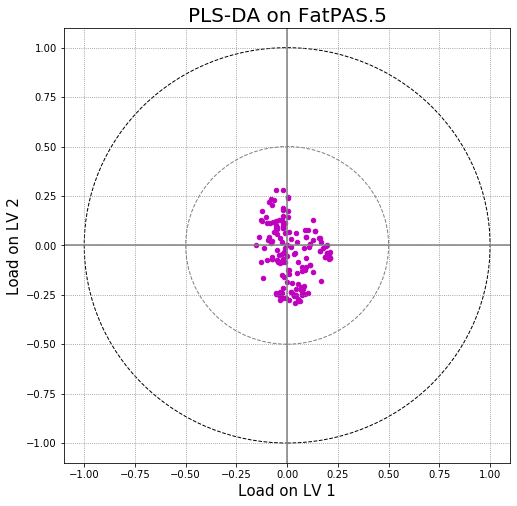

In [144]:
# --- 3 --- Final PLS model --------------------------------------------------

X_scores, Y_scores, X_loads, Y_loads = PLS_fit_model( XX, YY.loc[:, Response_Col], 5, Response_Col)

# --- 5 --- Plot LOADING -----------------------------------------------------

# Create a table with all that we need for plotting the desired results 
DF_scores = X_loads.copy() 

# We create a 2D scatter plot, we only need to take the first two latent 
# variables and the response column (the last). We color each category 
# (targets) with a unique color
plotDF = DF_scores.iloc[:,[0,1]]

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(1,1,1) 

# Plot the PCA in as 2D scatterplot and uniquely  color each flowcell data
ax.scatter( plotDF.loc[:, plotDF.columns[0]], 
            plotDF.loc[:, plotDF.columns[1]], 
            c = 'm',
            s = 20)

# Plot unit circle
circ = plt.Circle((0, 0), radius=1,   edgecolor='black', linestyle='--', facecolor='None')
ax.add_patch(circ)
circ = plt.Circle((0, 0), radius=0.5, edgecolor='grey',  linestyle='--', facecolor='None')
ax.add_patch(circ)
# Add gridlines, X and Y-axis at origin, and their style 
plt.grid(color = "grey", linestyle='dotted')
ax.axhline(y=0, linestyle='-', color='grey')
ax.axvline(x=0, linestyle='-', color='grey')

ax.set_xlabel('Load on LV 1', fontsize = 15)
ax.set_ylabel('Load on LV 2', fontsize = 15)
ax.set_title('PLS-DA on '+ Response_Col , fontsize = 20)
nn = 1.1
ax.set_xlim([-nn, nn])
ax.set_ylim([-nn, nn])


# --- SAVE the plot ----------------------------------------------------------
plt.savefig(root_path + "/Figures/Mix_5thTimepoint/PLSDA_load_"+ Response_Col+"_load_LP-MB_"+str(min_cat)+"_"+str(max_cat)+".png")

In [61]:
AA = pd.DataFrame( data = { "C1":[0,1,2,3,4,5,6,7,8,9],
                            "C2":[0,1,2,3,4,5,6,7,8,9],
                            "C3":["0","1","2","3","4","5","6","7","8","9"],
                            "C4":["0","1","2","3","4","5","6","7","8","9"]  
                          } )

BB = pd.DataFrame( data = { "C1":[0,1,2,3,4,5,6,7,8,9],
                            "C2":[0,1,1,3,3,5,5,7,7,0],
                            "C3":["0","1","2","3","4","5","6","7","8","9"],
                            "C4":["2","2","4","4","6","6","7","7","8","8"]  
                           } )

comparison = [ qq == ee for qq,ee in zip( AA["C1"], BB["C2"]) ]

#if   np.all(equality_check):
    # All values between the two columns are equal
    
#elif np.any(equality_check):
    # Only some values between columns are equal


# check uniqueness of lists

train_pID = np.setdiff1d( uID_List, test_pID )
train_idx = np.where( M_Y[uID_colname].isin( train_pID ))[0].tolist()


check_all = np.all(equality_check)
idx = np.where(comparison)[0].tolist()
idx

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

In [ ]:
# REQUIRES to install:
# > conda install -c bokeh selenium
# > conda install phantomjs
# 
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn

def save_df_as_image(df, path):
# Save the visualization of a pandas DataFrame as an image (.png or .svg)
    source = ColumnDataSource(df)
    df_columns = [df.index.name]
    df_columns.extend(df.columns.values)
    columns_for_table=[]
    for column in df_columns:
        columns_for_table.append(TableColumn(field=column, title=column))

    data_table = DataTable(source=source, columns=columns_for_table,height_policy="auto",width_policy="auto",index_position=None)
    export_png(data_table, filename = path)
    
save_df_as_image( accuracy, root_path + "/Figures/dfAccuracy"+ Response_Col+"_load_LP-MB_"+str(min_cat)+"_"+str(max_cat)+".png")    

In [6]:
CD_samples.loc[CD_samples["Timepoint_kodet"]==5, :]

,PatientID,Samplename,Names date modified,Samling date,Dato stråleterapi,Timepoint,Timepoint_kodet,Alder,BMI,HER2,ER,PGR,kjemo,herceptin,hormornbeh
4,17547,17547_05.03.08,17547_05.03.2008,05.03.2008,20/03/2007,12 months,5,59,25.1042,1,1,2,1,1,1
7,17548,17548_03.04.08,17548_03.04.2008,03.04.2008,19/03/2007,12 months,5,45,36.8442,0,1,3,1,0,1
14,17606,17606_21.05.08,17606_21.05.2008,21.05.2008,21/05/2007,12 months,5,50,23.7954,1,2,2,1,1,0
16,17805,17805_17.04.08,17805_17.04.2008,17.04.2008,15/03/2007,12 months,5,73,35.1,1,1,2,2,2,1
21,17830,17830_10.04.08,17830_10.04.2008,10.04.2008,26/02/2007,12 months,5,61,28.7105,0,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,19904,19904_30.09.2009,19904_30.09.2009,30.09.2009,18/09/2008,12 months,5,68,29,0,1,3,0,0,1
975,19930,19930_27.10.2009,19930_27.10.2009,27.10.2009,25/09/2008,12 months,5,50,26.2,0,1,3,1,0,1
978,19943,19943_14.08.2009,19943_14.08.2009,14.08.2009,01/10/2008,12 months,5,66,23.2377,0,1,3,0,0,0
981,19944,19944_03.11.2009,19944_03.11.2009,03.11.2009,01/10/2008,12 months,5,55,25.9259,0,1,3,0,0,1


In [116]:
YY = CD_samples.copy()
dataset = pd.concat([LP_measure, MB_measure.iloc[:,2:]], axis = 1)
timepoipnt = 5

# Select timepoint
mask = YY["Timepoint_kodet"]== 5
YY = YY.loc[mask]
dataset = dataset.loc[mask]

# Remove NaN values
mask = YY["FatPAS.5"].isnull().values
YY = YY.loc[ ~mask, : ]
dataset = dataset.loc[ ~mask, : ]

YY.loc[ YY["FatPAS.5"]==1, "FatPAS.5"] = 0
YY.loc[ YY["FatPAS.5"]>=2, "FatPAS.5"] = 1
YY

,PatientID,Samplename,Names date modified,Samling date,Dato stråleterapi,Timepoint,Timepoint_kodet,Alder,BMI,HER2,ER,PGR,kjemo,herceptin,hormornbeh,FatPAS.1,FatPAS.2,FatPAS.3,FatPAS.4,FatPAS.5
4,17547,17547_05.03.08,17547_05.03.2008,05.03.2008,20/03/2007,12 months,5,59,25.1042,1,1,2,1,1,1,4,2,NaN,3,1
7,17548,17548_03.04.08,17548_03.04.2008,03.04.2008,19/03/2007,12 months,5,45,36.8442,0,1,3,1,0,1,1,2,2,3,0
14,17606,17606_21.05.08,17606_21.05.2008,21.05.2008,21/05/2007,12 months,5,50,23.7954,1,2,2,1,1,0,2,4,2,3,1
16,17805,17805_17.04.08,17805_17.04.2008,17.04.2008,15/03/2007,12 months,5,73,35.1,1,1,2,2,2,1,2,2,2,2,1
21,17830,17830_10.04.08,17830_10.04.2008,10.04.2008,26/02/2007,12 months,5,61,28.7105,0,1,3,0,0,0,1,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,19877,19877_29.10.2009,19877_29.10.2009,29.10.2009,09/09/2008,12 months,5,52,28.1,0,1,3,0,0,0,1,3,1,1,0
972,19904,19904_30.09.2009,19904_30.09.2009,30.09.2009,18/09/2008,12 months,5,68,29,0,1,3,0,0,1,2,2,2,2,1
975,19930,19930_27.10.2009,19930_27.10.2009,27.10.2009,25/09/2008,12 months,5,50,26.2,0,1,3,1,0,1,3,3,2,4,1
981,19944,19944_03.11.2009,19944_03.11.2009,03.11.2009,01/10/2008,12 months,5,55,25.9259,0,1,3,0,0,1,1,1,2,3,0


In [174]:
oY_test = comparPred["oY_test"]
oY_pred_thres = comparPred["Y_pred_thres"]

# True Negat.      True Posit.      False Negat.      False Posit.
TN = 0;            TP = 0;          FN = 0;           FP = 0;

for ii in range(len(oY_test)):
    if   oY_test[ii]==0 and oY_pred_thres[ii]==0 :     TN +=1   # True Negative
    elif oY_test[ii]==1 and oY_pred_thres[ii]==1 :     TP +=1   # True Positive
    elif oY_test[ii]==1 and oY_pred_thres[ii]==0 :     FN +=1   # False Negative
    elif oY_test[ii]==0 and oY_pred_thres[ii]==1 :     FP +=1   # False Positive
        

specificity = FP / (FP+TN)
sensitivity = TP / (TP+FN)
print("TN:  ", TN)
print("TP:  ", TP)
print("FN:  ", FN)
print("FP:  ", FP)
print("Tot: ", len(oY_test))

print("specificity:  ", specificity)
print("sensitivity:  ", sensitivity)

TN:   6
TP:   7
FN:   9
FP:   6
Tot:  28
specificity:   0.5
sensitivity:   0.4375


In [156]:
comparPred

,oY_test,oY_pred,Y_pred_thres,T-F
0,0,0.242459,0,True
1,0,0.906016,1,False
2,0,1.66374,1,False
3,1,1.35754,1,True
4,1,0.952861,1,True
5,0,0.0574714,0,True
6,0,0.269098,0,True
7,1,-0.311018,0,False
8,1,0.494662,0,False
9,0,1.03575,1,False
